# Exploratory Data Analysis (EDA)
#### Eloisa Tran - Data Scientist
___



## Q1 - 2016 (stage_1)
___

## Data Source
### Statements 
1. Stage_1 - two weeks timeline project plan
+ Stage_1 - focus in obtain fake reviews using supervised learning with linguistic features only. 
+ Stage_1 - Fake Reviews crawled from yelp.com, columns were limited to 7 essential features for our test models.
+ Training dataset has a ratio of 50:50 i.e. it contains 50% of fake reviews and 50% of genuine reviews.
    * 39140 Genuine Reviews from Yelp Data Challenge - df_rbu
    * 39140 Fake Reviews crawled from yelp.com

#### * Yelp  Challenge Datasets are considered genuine reviews
#### * Fraudulent reviews are  crawled  from  yelp.com
![AWS Lambda architecture](https://s3-us-west-2.amazonaws.com/fake-reviews-project/02_data_source.png)


In [2]:
from __future__ import division
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import random

from pandas.tools.plotting import scatter_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%pylab inline

%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


___

# Yelp  Challenge Dataset

___
## EDA _review


Dataset - review (`yelp_academic_dataset_review.json`)

```
{
     'type': 'review',
     'business_id': (encrypted business id),
     'user_id': (encrypted user id),
     'stars': (star rating, rounded to half-stars),
     'text': (review text),
     'date': (date, formatted like '2012-03-14'),
     'votes': {(vote type): (count)},
}

```

In [4]:
df_reviews = pd.read_csv('yelp_academic_dataset_review.csv')

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1569265 entries, 0 to 1569264
Data columns (total 10 columns):
business_id     1569265 non-null object
date            1569265 non-null object
review_id       1569265 non-null object
stars           1569265 non-null int64
text            1569264 non-null object
type            1569264 non-null object
user_id         1569263 non-null object
votes_cool      1569263 non-null float64
votes_funny     1569263 non-null float64
votes_useful    1569263 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 131.7+ MB


#### Evaluating  distinct values in review_id 
#### Conclusion: All the reviews are unique

In [7]:
(df_reviews['review_id'].value_counts() == 1).sum()

1569265

#### Renaming columns

In [8]:
df_reviews.rename(columns={'stars': 'stars_review', 'type':'type_review', 'text':'text_review'}, inplace=True)

In [120]:
df_reviews.head(1)

,business_id,date,review_id,stars_review,text_review,type_review,user_id,votes_cool,votes_funny,votes_useful
0,vcNAWiLM4dR7D2nwwJ7nCA,2007-05-17,15SdjuK7DmYqUAj6rjGowg,5,dr. goldberg offers everything i look for in a...,review,Xqd0DzHaiyRqVH3WRG7hzg,1,0,2


#### Datatype

In [10]:
df_reviews = df_reviews[df_reviews['date'] != 'review']

In [11]:
df_reviews['date'].value_counts().sum()

1569264

In [12]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

____
## EDA _business


Dataset - business (`yelp_academic_dataset_business.json`)

```
{
     'type': 'business',
     'business_id': (encrypted business id),
     'name': (business name),
     'neighborhoods': [(hood names)],
     'full_address': (localized address),
     'city': (city),
     'state': (state),
     'latitude': latitude,
     'longitude': longitude,
     'stars': (star rating, rounded to half-stars),
     'review_count': review count,
     'categories': [(localized category names)]
     'open': True / False (corresponds to closed, not business hours),
     'hours': {
         (day_of_week): {
             'open': (HH:MM),
             'close': (HH:MM)
},
... 
},
     'attributes': {
         (attribute_name): (attribute_value),
         ...
}, }
```

In [13]:
df_business = pd.read_csv('yelp_academic_dataset_business.csv')
df_business.head(1)

,Unnamed: 0,Unnamed: 0.1,business_id,categories,city,latitude,longitude,name,open,review_count,stars,state,type
0,0,0,vcNAWiLM4dR7D2nwwJ7nCA,"[Doctors, Health & Medical]",Phoenix,33.499313,-111.983758,"Eric Goldberg, MD",True,9,3.5,AZ,business


In [46]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61184 entries, 0 to 61183
Data columns (total 11 columns):
business_id              61184 non-null object
categories               61184 non-null object
city                     61184 non-null object
latitude                 61184 non-null float64
longitude                61184 non-null float64
name_business            61184 non-null object
open                     61184 non-null bool
review_count_business    61184 non-null int64
stars_business           61184 non-null float64
state                    61184 non-null object
type_business            61184 non-null object
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 5.2+ MB


In [15]:
df_business.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)

In [36]:
df_business.rename(columns={'name':'name_business','review_count': 'review_count_business','stars':'stars_business', 'type':'type_business'}, inplace=True)
df_business.head(1)

,business_id,categories,city,latitude,longitude,name_business,open,review_count_business,stars_business,state,type_business
0,vcNAWiLM4dR7D2nwwJ7nCA,"[Doctors, Health & Medical]",Phoenix,33.499313,-111.983758,"Eric Goldberg, MD",True,9,3.5,AZ,business


#### Merging data frames to create df_temp
#### business dataset - review dataset

In [40]:
df_temp = df_reviews.merge(df_business, how='left', on='business_id')

In [41]:
df_temp.head(5)

,business_id,date,review_id,stars_review,text_review,type_review,user_id,votes_cool,votes_funny,votes_useful,categories,city,latitude,longitude,name_business,open,review_count_business,stars_business,state,type_business
0,vcNAWiLM4dR7D2nwwJ7nCA,2007-05-17,15SdjuK7DmYqUAj6rjGowg,5,dr. goldberg offers everything i look for in a...,review,Xqd0DzHaiyRqVH3WRG7hzg,1,0,2,"[Doctors, Health & Medical]",Phoenix,33.499313,-111.983758,"Eric Goldberg, MD",True,9,3.5,AZ,business
1,vcNAWiLM4dR7D2nwwJ7nCA,2010-03-22,RF6UnRTtG7tWMcrO2GEoAg,2,"Unfortunately, the frustration of being Dr. Go...",review,H1kH6QZV7Le4zqTRNxoZow,0,0,2,"[Doctors, Health & Medical]",Phoenix,33.499313,-111.983758,"Eric Goldberg, MD",True,9,3.5,AZ,business
2,vcNAWiLM4dR7D2nwwJ7nCA,2012-02-14,-TsVN230RCkLYKBeLsuz7A,4,Dr. Goldberg has been my doctor for years and ...,review,zvJCcrpm2yOZrxKffwGQLA,1,0,1,"[Doctors, Health & Medical]",Phoenix,33.499313,-111.983758,"Eric Goldberg, MD",True,9,3.5,AZ,business
3,vcNAWiLM4dR7D2nwwJ7nCA,2012-03-02,dNocEAyUucjT371NNND41Q,4,Been going to Dr. Goldberg for over 10 years. ...,review,KBLW4wJA_fwoWmMhiHRVOA,0,0,0,"[Doctors, Health & Medical]",Phoenix,33.499313,-111.983758,"Eric Goldberg, MD",True,9,3.5,AZ,business
4,vcNAWiLM4dR7D2nwwJ7nCA,2012-05-15,ebcN2aqmNUuYNoyvQErgnA,4,Got a letter in the mail last week that said D...,review,zvJCcrpm2yOZrxKffwGQLA,1,0,2,"[Doctors, Health & Medical]",Phoenix,33.499313,-111.983758,"Eric Goldberg, MD",True,9,3.5,AZ,business


____
## EDA _user

Dataset - user (`yelp_academic_dataset_user.json`)

```
￼ {
     'type': 'user',
     'user_id': (encrypted user id),
     'name': (first name),
     'review_count': (review count),
     'average_stars': (floating point average, like 4.31),
     'votes': {(vote type): (count)},
     'friends': [(friend user_ids)],
     'elite': [(years_elite)],
     'yelping_since': (date, formatted like '2012-03'),
     'compliments': {
         (compliment_type): (num_compliments_of_this_type),
... },
     'fans': (num_fans),
 }
```

In [21]:
df_user = pd.read_csv('yelp_academic_dataset_user.csv')

In [39]:
df_user.rename(columns={'yelp_since':'yelp_since_user','review_count':'review_count_user','friends':'friends_user','fan':'fan_user','type':'type_user','name':'name_user'}, inplace=True)
df_user.head(1)

,yelping_since,compliments.plain,review_count_user,friends_user,compliments.cute,compliments.writer,fans,compliments.note,type_user,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,elite,name_user,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,25,108,"['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bx...",15,9,69,20,user,48,78,8,4.14,3,"[2005, 2006]",Russel,18kPq7GPye-YQ3LyKyAZPw,245,NaN,166,15,11,278


#### Merging data frames to create df_rbu --> df(reviews, business, user)
#### temporary dataset - user dataset

In [42]:
df_rbu = df_user.merge(df_temp, how='left', on='user_id')

In [43]:
df_rbu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1569263 entries, 0 to 1569262
Data columns (total 42 columns):
yelping_since            1569263 non-null object
compliments.plain        816830 non-null float64
review_count_user        1569263 non-null int64
friends_user             1569263 non-null object
compliments.cute         331893 non-null float64
compliments.writer       700818 non-null float64
fans                     1569263 non-null int64
compliments.note         772553 non-null float64
type_user                1569263 non-null object
compliments.hot          654216 non-null float64
compliments.cool         787831 non-null float64
compliments.profile      345813 non-null float64
average_stars            1569263 non-null float64
compliments.more         560751 non-null float64
elite                    1569263 non-null object
name_user                1569263 non-null object
user_id                  1569263 non-null object
votes.cool               1569263 non-null int64
complim

In [44]:
pd.set_option('display.max_columns', 42)

In [45]:
df_rbu.head(1)

,yelping_since,compliments.plain,review_count_user,friends_user,compliments.cute,compliments.writer,fans,compliments.note,type_user,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,elite,name_user,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,business_id,date,review_id,stars_review,text_review,type_review,votes_cool,votes_funny,votes_useful,categories,city,latitude,longitude,name_business,open,review_count_business,stars_business,state,type_business
0,2004-10,25,108,"['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bx...",15,9,69,20,user,48,78,8,4.14,3,"[2005, 2006]",Russel,18kPq7GPye-YQ3LyKyAZPw,245,NaN,166,15,11,278,zMN8UGd1zDEreT58OCdnyg,2004-10-19,HdODbQJU0D814XdwBxXRfw,5,Best pizza I've ever had. My favorite is the ...,review,0,0,2,"[Pizza, Restaurants]",Champaign,40.110527,-88.236332,Papa Del's Pizza,True,207,4,IL,business


___
## Yelp dataset challenge - This set includes information about local businesses in 10 cities across 4 countries.

▪ U.K.: Edinburgh

▪ Germany: Karlsruhe

▪ Canada: Montreal and Waterloo

▪ U.S.: Pittsburgh, Charlotte, Urbana-Champaign, Phoenix, Las Vegas, Madison 

#### According with the project scope and for the purpose of this project  we focus in US.

* Pittsburgh
* Charlotte
* Urbana-Champaign
* Phoenix
* Las Vegas
* Madison 


In [48]:
df_rbu = df_rbu[df_rbu['city'].isin(['Pittsburgh', 'Chralotte', 'Charlotte', 'Urbana-Champaign', 'Phoenix', 'Las Vegas', 'Madison'])]
df_rbu.head(1)

,yelping_since,compliments.plain,review_count_user,friends_user,compliments.cute,compliments.writer,fans,compliments.note,type_user,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,elite,name_user,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,business_id,date,review_id,stars_review,text_review,type_review,votes_cool,votes_funny,votes_useful,categories,city,latitude,longitude,name_business,open,review_count_business,stars_business,state,type_business
1,2004-10,921,1233,"['18kPq7GPye-YQ3LyKyAZPw', '4U9kSBLuBDU391x6bx...",209,290,1012,589,user,1032,1521,110,3.64,129,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,9837,37,6849,287,561,12642,hW0Ne_HTHEAgGF1rAdmR-g,2010-10-28,iW-vB9UD89solHK8mhB4lA,4,"You'll appreciate the decent food options, fre...",review,8,7,11,"[Hotels & Travel, Airports]",Phoenix,33.43475,-112.006439,Phoenix Sky Harbor International Airport,True,1512,3.5,AZ,business


In [33]:
df_rbu.city.value_counts()

Las Vegas     617357
Phoenix       219815
Charlotte      86952
Pittsburgh     62325
Madison        37071
Name: city, dtype: int64

___
## Yelp dataset challenge - This set includes information about several categories for local businesses 

#### According with the project scope and for the purpose of this project  we focus in ***Restaurants & Food***

In [49]:
df_rbu = df_rbu[df_rbu['categories'].str.contains('Restaurants','Food')]

In [50]:
df_rbu.head(1)

,yelping_since,compliments.plain,review_count_user,friends_user,compliments.cute,compliments.writer,fans,compliments.note,type_user,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,elite,name_user,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,business_id,date,review_id,stars_review,text_review,type_review,votes_cool,votes_funny,votes_useful,categories,city,latitude,longitude,name_business,open,review_count_business,stars_business,state,type_business
10,2004-10,921,1233,"['18kPq7GPye-YQ3LyKyAZPw', '4U9kSBLuBDU391x6bx...",209,290,1012,589,user,1032,1521,110,3.64,129,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,9837,37,6849,287,561,12642,4EhFsjWBSaSp_5TkkLp7LA,2013-04-26,ETRdmj8x54HhzT2yc_E85Q,4,A surprisingly intimate restaurant in the Bell...,review,8,5,14,"[French, Restaurants]",Las Vegas,36.113127,-115.175263,Le Cirque,True,397,4,NV,business


In [52]:
df_rbu.categories.value_counts()

[Mexican, Restaurants]                                                                    34856
[American (New), Restaurants]                                                             19089
[Restaurants, Italian]                                                                    18075
[Buffets, Restaurants]                                                                    17722
[American (Traditional), Restaurants]                                                     16180
[Sushi Bars, Japanese, Restaurants]                                                       15726
[Pizza, Restaurants]                                                                      15038
[Chinese, Restaurants]                                                                    12864
[Steakhouses, Restaurants]                                                                12405
[Thai, Restaurants]                                                                       12316
[Burgers, Restaurants]                  

In [54]:
df_rbu['friends_user'].isnull().values.any()

False

In [57]:
df_rbu.friends_user.count()

641692

In [105]:
df_rbu['friend_count'] = df_rbu['friends_user'].apply(len)

In [106]:
df_rbu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641692 entries, 10 to 1569260
Data columns (total 43 columns):
yelping_since            641692 non-null object
compliments.plain        343295 non-null float64
review_count_user        641692 non-null int64
friends_user             641692 non-null object
compliments.cute         134673 non-null float64
compliments.writer       296735 non-null float64
fans                     641692 non-null int64
compliments.note         321751 non-null float64
type_user                641692 non-null object
compliments.hot          274581 non-null float64
compliments.cool         335978 non-null float64
compliments.profile      143535 non-null float64
average_stars            641692 non-null float64
compliments.more         240447 non-null float64
elite                    641692 non-null object
name_user                641692 non-null object
user_id                  641692 non-null object
votes.cool               641692 non-null int64
compliments.list 

In [107]:
pd.set_option('display.max_columns', 43)

In [108]:
df_rbu.head(1)

,yelping_since,compliments.plain,review_count_user,friends_user,compliments.cute,compliments.writer,fans,compliments.note,type_user,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,elite,name_user,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,business_id,date,review_id,stars_review,text_review,type_review,votes_cool,votes_funny,votes_useful,categories,city,latitude,longitude,name_business,open,review_count_business,stars_business,state,type_business,friend_count
10,2004-10,921,1233,"['18kPq7GPye-YQ3LyKyAZPw', '4U9kSBLuBDU391x6bx...",209,290,1012,589,user,1032,1521,110,3.64,129,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,9837,37,6849,287,561,12642,4EhFsjWBSaSp_5TkkLp7LA,2013-04-26,ETRdmj8x54HhzT2yc_E85Q,4,A surprisingly intimate restaurant in the Bell...,review,8,5,14,"[French, Restaurants]",Las Vegas,36.113127,-115.175263,Le Cirque,True,397,4,NV,business,49504


#### Confirm Unique review_id from df_rbu_us_r

In [109]:
df_rbu['review_id'].value_counts().sum()

641692

In [110]:
df_rbu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641692 entries, 10 to 1569260
Data columns (total 43 columns):
yelping_since            641692 non-null object
compliments.plain        343295 non-null float64
review_count_user        641692 non-null int64
friends_user             641692 non-null object
compliments.cute         134673 non-null float64
compliments.writer       296735 non-null float64
fans                     641692 non-null int64
compliments.note         321751 non-null float64
type_user                641692 non-null object
compliments.hot          274581 non-null float64
compliments.cool         335978 non-null float64
compliments.profile      143535 non-null float64
average_stars            641692 non-null float64
compliments.more         240447 non-null float64
elite                    641692 non-null object
name_user                641692 non-null object
user_id                  641692 non-null object
votes.cool               641692 non-null int64
compliments.list 

___
# Q1 - 2016 (stage_1)
___
## Sampling
### Training dataset has a ratio of 50:50 i.e. it contains 50% of fake reviews and 50% of genuine reviews.
    * 39140 Genuine Reviews from Yelp Data Challenge - df_rbu
    * 39140 Fake Reviews crawled from yelp.com


In [77]:
sub_rows = np.random.choice(df_rbu.index.values, df_rbu.shape[0]*0.061)
df_gsample = df_rbu.ix[sub_rows]

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


In [78]:
df_gsample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39143 entries, 970789 to 637990
Data columns (total 43 columns):
yelping_since            39143 non-null object
compliments.plain        20832 non-null float64
review_count_user        39143 non-null int64
friends_user             39143 non-null object
compliments.cute         8084 non-null float64
compliments.writer       17956 non-null float64
fans                     39143 non-null int64
compliments.note         19479 non-null float64
type_user                39143 non-null object
compliments.hot          16550 non-null float64
compliments.cool         20435 non-null float64
compliments.profile      8549 non-null float64
average_stars            39143 non-null float64
compliments.more         14543 non-null float64
elite                    39143 non-null object
name_user                39143 non-null object
user_id                  39143 non-null object
votes.cool               39143 non-null int64
compliments.list         6163 non-n

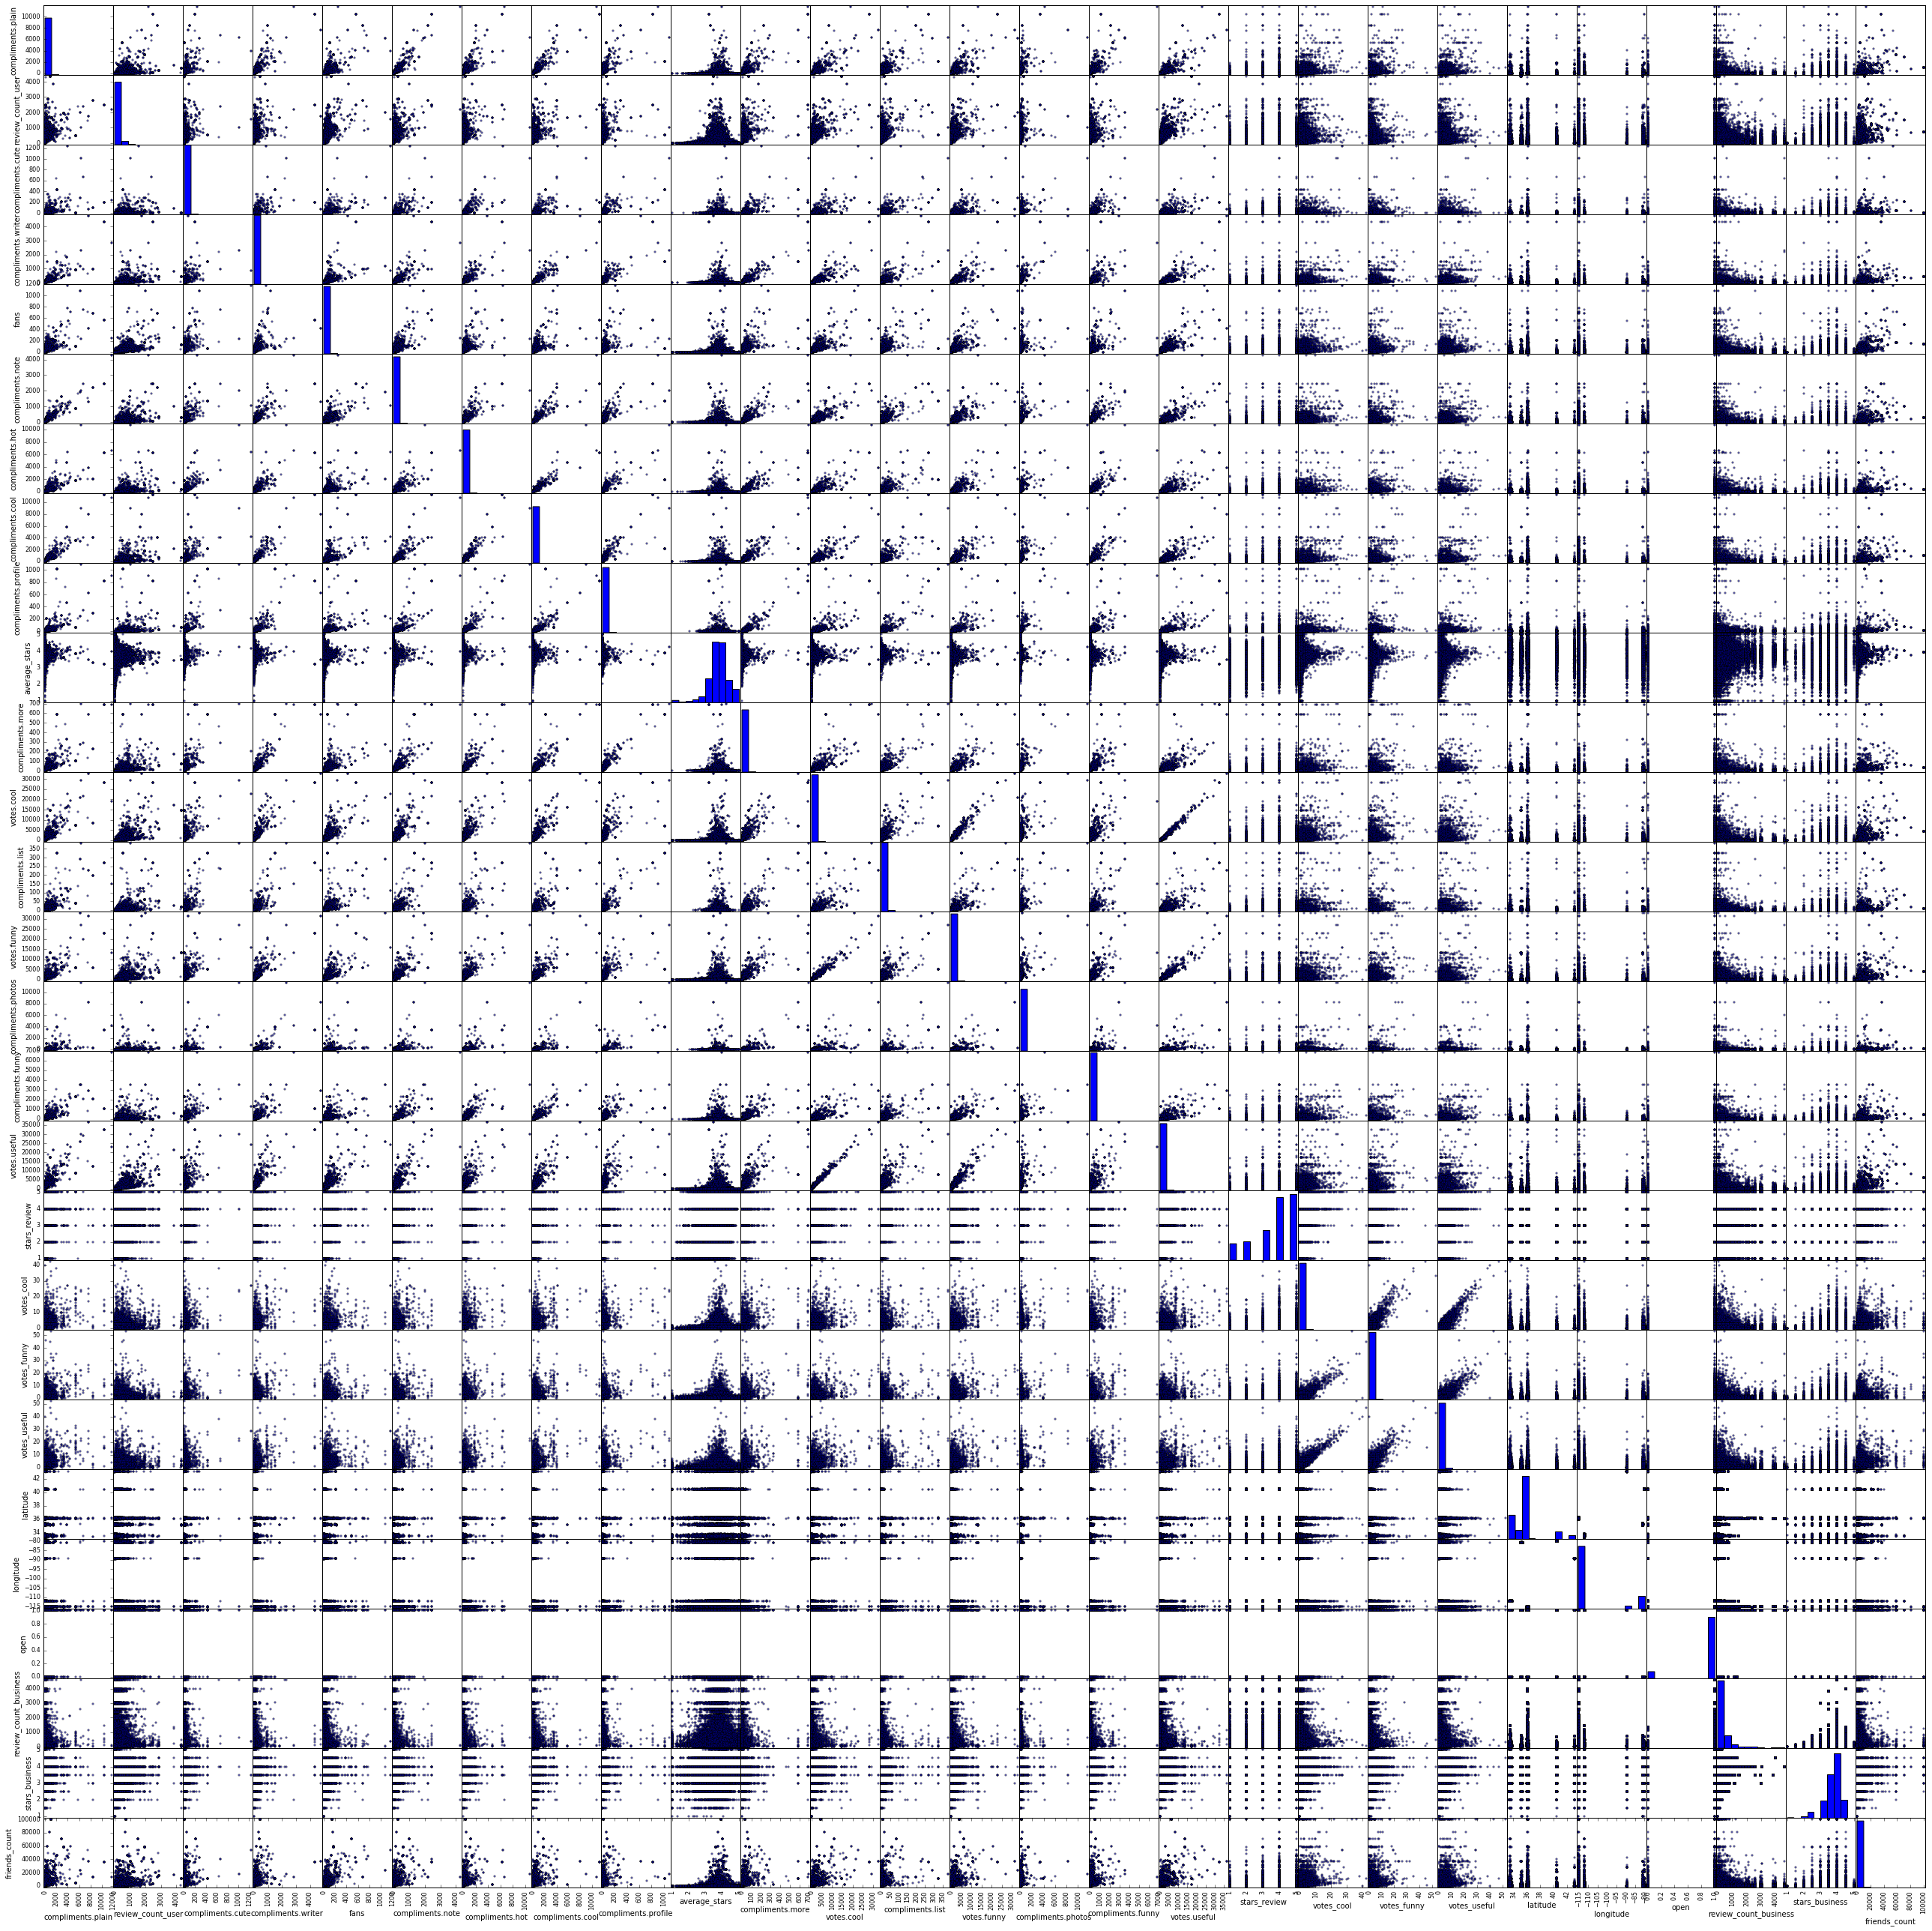

In [198]:
matrix_f = scatter_matrix(df_gsample, figsize=(45,45))

___
# EDA Not recommended - Fake Reviews(business)

___

Dataset - business_not_recommended (`y_businesses.csv`)

```
{
    'search_results_index':search_results_index, 
    'business_name':business_name,
    'business_id':(business_name_id),
    'data_hovercard_id':(encrypted business id), 
    'rating':(star rating, rounded to half-stars),
    'review_count':(number of total reviews),
    'price_range':price_range,
    'neighborhood':[(hood names)],
    'address':address,
    'phone':phone,
    'categories':[(localized category names)], 
    'searched_city':(city),
    'searched_state':(state)
       
       }

```



In [177]:
df_temp_nr= pd.read_csv('y_businesses.csv')
df_temp_nr.head(1)

,search_results_index,business_name,business_id,data_hovercard_id,rating,review_count,price_range,neighborhood,address,phone,categories,searched_city,searched_state
0,561,Grand View Buffet,grand-view-buffet-pittsburgh,9aMJ0KsMkEoeygdj7RCrIw,3.0,43,$$,North Side,"777 Casino Dr, Pittsburgh, PA 15212",(412) 231-7777,"American (New), Buffets, Barbeque",Pittsburgh,PA


In [178]:
df_temp_nr.data_hovercard_id.unique

<bound method Series.unique of 0       9aMJ0KsMkEoeygdj7RCrIw
1       sAvcXKXXqDjWIGdCDqOcGw
2       ng6m7Owr9EyZ1otCwHJShQ
3       Z8VjlhuOhW4zZVFR02hfYA
4       LrJMm9-slNyAMlzmEFAWvw
5       SSeaU0wApBQ__9fBoUaw6g
6       zAzU6sAFKhw5zF9--NiuIQ
7       0uiKRWCIUz6zMP8Yu-ADlQ
8       aVQaxXSNhcla0BBbODF1nQ
9       zCh5A_ZEbOgRlmF_7cKb0w
10      dFx9lWpaYe_PCbKaZ0C1Rw
11      qFhqMbtat9BcMZ44H8MKqA
12      wPSz1ZFDEpyw1RGAkYUWIA
13      VXSz7v-HQYNc8i4ATTNfWw
14      NDxnatqnkCgTq_lysXa00A
15      qIuwz1s1yoNt5c7gCaLvJw
16      GGIRNcKIizEEsad8fjSEug
17      PdyM91KjMVmk2QWTsespJw
18      lGQi6dQzVhOPVv5RNhHHDw
19      PR5P3HTcmsbdNQYl0_9Jsw
20      akycdKVLuqr8c5B2wy7Qiw
21      satHPUw636DlX9Sd16Dktw
22      zsqZuSebUG1NhGygbjihXA
23      0KFscFohhLw_9Die94rEVg
24      aNVTMTZPFUgFeTBGAkIfTg
25      gXgN-4oZ507RGDAPa5Ndmw
26      Wb30iey4XaSHB5vCgZmOcA
27      3iN9bZlZY2qr32HBL8NO6g
28      lxW78SIcTFp8rU8PHAGQ3A
29      RbaHbcb6xjGhEy4b9WC0tg
                 ...          
5370    

In [179]:
df_temp_nr.rename(columns={'business_name': 'name_business', 'data_hovercard_id':'business_id_encripted', 'rating': 'stars_business', 'review_count': 'review_count_business'}, inplace=True)

In [180]:
df_temp_nr.head(1)

,search_results_index,name_business,business_id,business_id_encripted,stars_business,review_count_business,price_range,neighborhood,address,phone,categories,searched_city,searched_state
0,561,Grand View Buffet,grand-view-buffet-pittsburgh,9aMJ0KsMkEoeygdj7RCrIw,3.0,43,$$,North Side,"777 Casino Dr, Pittsburgh, PA 15212",(412) 231-7777,"American (New), Buffets, Barbeque",Pittsburgh,PA


In [181]:
df_temp_nr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5400 entries, 0 to 5399
Data columns (total 13 columns):
search_results_index     5400 non-null int64
name_business            5400 non-null object
business_id              5400 non-null object
business_id_encripted    5400 non-null object
stars_business           5400 non-null object
review_count_business    5400 non-null int64
price_range              5400 non-null object
neighborhood             5400 non-null object
address                  5400 non-null object
phone                    5258 non-null object
categories               5400 non-null object
searched_city            5400 non-null object
searched_state           5400 non-null object
dtypes: int64(2), object(11)
memory usage: 590.6+ KB


___
# EDA Not recommended - Fake Reviews

___

Dataset - business_not_recommended (`y_non_recommendations.csv`)

```
{
 
'business_id': business_id, 
'data_hovercard_id':(user_id) , 
'friend_count': friend_count,
'rating': (star rating, rounded to half-stars), 
'rating_qualifier': (date), 
'review': (text_review) ' 

       }

```



In [182]:
df_not_rec = pd.read_csv('y_non_recommendations.csv', error_bad_lines=False)

Skipping line 31: expected 7 fields, saw 12
Skipping line 44: expected 7 fields, saw 17
Skipping line 60: expected 7 fields, saw 12
Skipping line 79: expected 7 fields, saw 9
Skipping line 117: expected 7 fields, saw 11
Skipping line 143: expected 7 fields, saw 10
Skipping line 155: expected 7 fields, saw 20
Skipping line 157: expected 7 fields, saw 9
Skipping line 159: expected 7 fields, saw 8
Skipping line 171: expected 7 fields, saw 12
Skipping line 181: expected 7 fields, saw 9
Skipping line 186: expected 7 fields, saw 21
Skipping line 254: expected 7 fields, saw 11
Skipping line 257: expected 7 fields, saw 10
Skipping line 258: expected 7 fields, saw 8
Skipping line 259: expected 7 fields, saw 8
Skipping line 261: expected 7 fields, saw 23
Skipping line 262: expected 7 fields, saw 12
Skipping line 281: expected 7 fields, saw 18
Skipping line 318: expected 7 fields, saw 14
Skipping line 339: expected 7 fields, saw 10
Skipping line 381: expected 7 fields, saw 29
Skipping line 382: e

In [183]:
df_not_rec.pop('name')

0             James B.
1             Frank R.
2              Matt F.
3            Joanie F.
4           Michael K.
5              Jack P.
6              Rant J.
7             Louis G.
8              Jack J.
9              Jill M.
10           Kevlai P.
11              Sam H.
12           Charla O.
13             Mike F.
14             Leah W.
15         Victoria D.
16            Katie H.
17             Leah T.
18            Ginny A.
19          Michael J.
20         Jah'Zion W.
21            Emily T.
22             Gigi S.
23            Frank L.
24           Teresa O.
25         Christal A.
26            Signe M.
27           Krissy S.
28           Ashlyn S.
29         Luminita H.
             ...      
39068        Audrey S.
39069             J S.
39070         Amber B.
39071         Hovik B.
39072         Wendy C.
39073     Christina D.
39074        Sandra R.
39075          Todd F.
39076             G J.
39077          Gray D.
39078       Richard D.
39079      Margaret H.
39080      

In [184]:
df_not_rec.head(1)

,business_id,data_hovercard_id,friend_count,rating,rating_qualifier,review
0,ferraros-italian-restaurant-and-wine-bar-las-v...,e6sU_apm8xcEv8ae20dGzQ,0,4,3/30/2010,We had a table of 7 this past week and we were...


In [185]:
df_not_rec.rename(columns={'data_hovercard_id':'user_id', 'rating': 'stars_review', 'review':'text_review'}, inplace=True)

In [186]:
df_not_rec.head(1)

,business_id,user_id,friend_count,stars_review,rating_qualifier,text_review
0,ferraros-italian-restaurant-and-wine-bar-las-v...,e6sU_apm8xcEv8ae20dGzQ,0,4,3/30/2010,We had a table of 7 this past week and we were...


In [187]:
df_not_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39098 entries, 0 to 39097
Data columns (total 6 columns):
business_id         39098 non-null object
user_id             39098 non-null object
friend_count        39098 non-null int64
stars_review        39098 non-null float64
rating_qualifier    39098 non-null object
text_review         39098 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 2.1+ MB


In [188]:
df_nr = df_not_rec.merge(df_temp_nr, how='left', on='business_id')

In [195]:
df_nr.head(1)

,business_id,user_id,friend_count,stars_review,rating_qualifier,text_review,search_results_index,name_business,business_id_encripted,stars_business,review_count_business,price_range,neighborhood,address,phone,categories,searched_city,searched_state
0,ferraros-italian-restaurant-and-wine-bar-las-v...,e6sU_apm8xcEv8ae20dGzQ,0,4,3/30/2010,We had a table of 7 this past week and we were...,369,Ferraro’s Italian Restaurant & Wine Bar,GpIZgQ5stxnbXLiOM4NAlQ,4.0,504,$$$,Eastside,"4480 Paradise Rd, Las Vegas, NV 89169",(702) 364-5300,"Italian, Wine Bars",Las Vegas,NV


In [196]:
df_nr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39140 entries, 0 to 39139
Data columns (total 18 columns):
business_id              39140 non-null object
user_id                  39140 non-null object
friend_count             39140 non-null int64
stars_review             39140 non-null float64
rating_qualifier         39140 non-null object
text_review              39140 non-null object
search_results_index     39140 non-null int64
name_business            39140 non-null object
business_id_encripted    39140 non-null object
stars_business           39140 non-null object
review_count_business    39140 non-null int64
price_range              39140 non-null object
neighborhood             39140 non-null object
address                  39140 non-null object
phone                    38964 non-null object
categories               39140 non-null object
searched_city            39140 non-null object
searched_state           39140 non-null object
dtypes: float64(1), int64(3), object(14)
memory

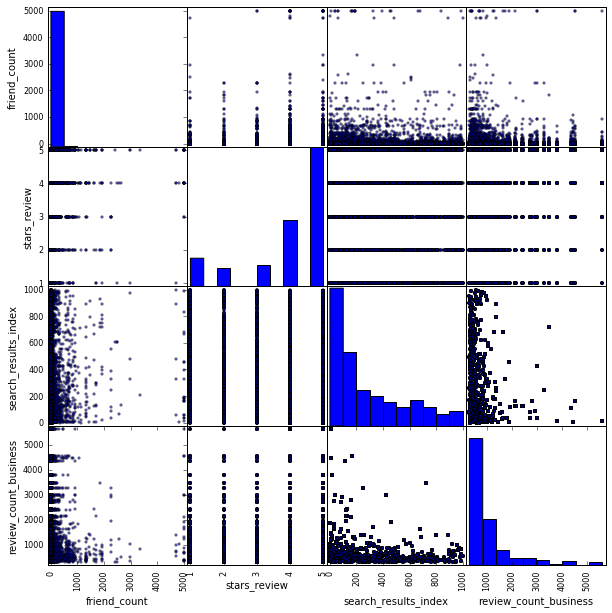

In [197]:
matrix_f = scatter_matrix(df_nr, figsize=(10, 10))